In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from fastai.text.all import *

## 1. Let's see the data after oversampling

In [2]:
df_tl = pd.read_csv('ql_oversampled.csv')
df_tl.tail()

,text,label
11190,do i envolved to stocks up on food,61
11191,to i need to neckcloth up 0n solid food,61
11192,do unity need ou parentage up on foor,61
11193,make i need to stock p onf food,61
11194,''m I’ve need to lineage up on nutrient,61


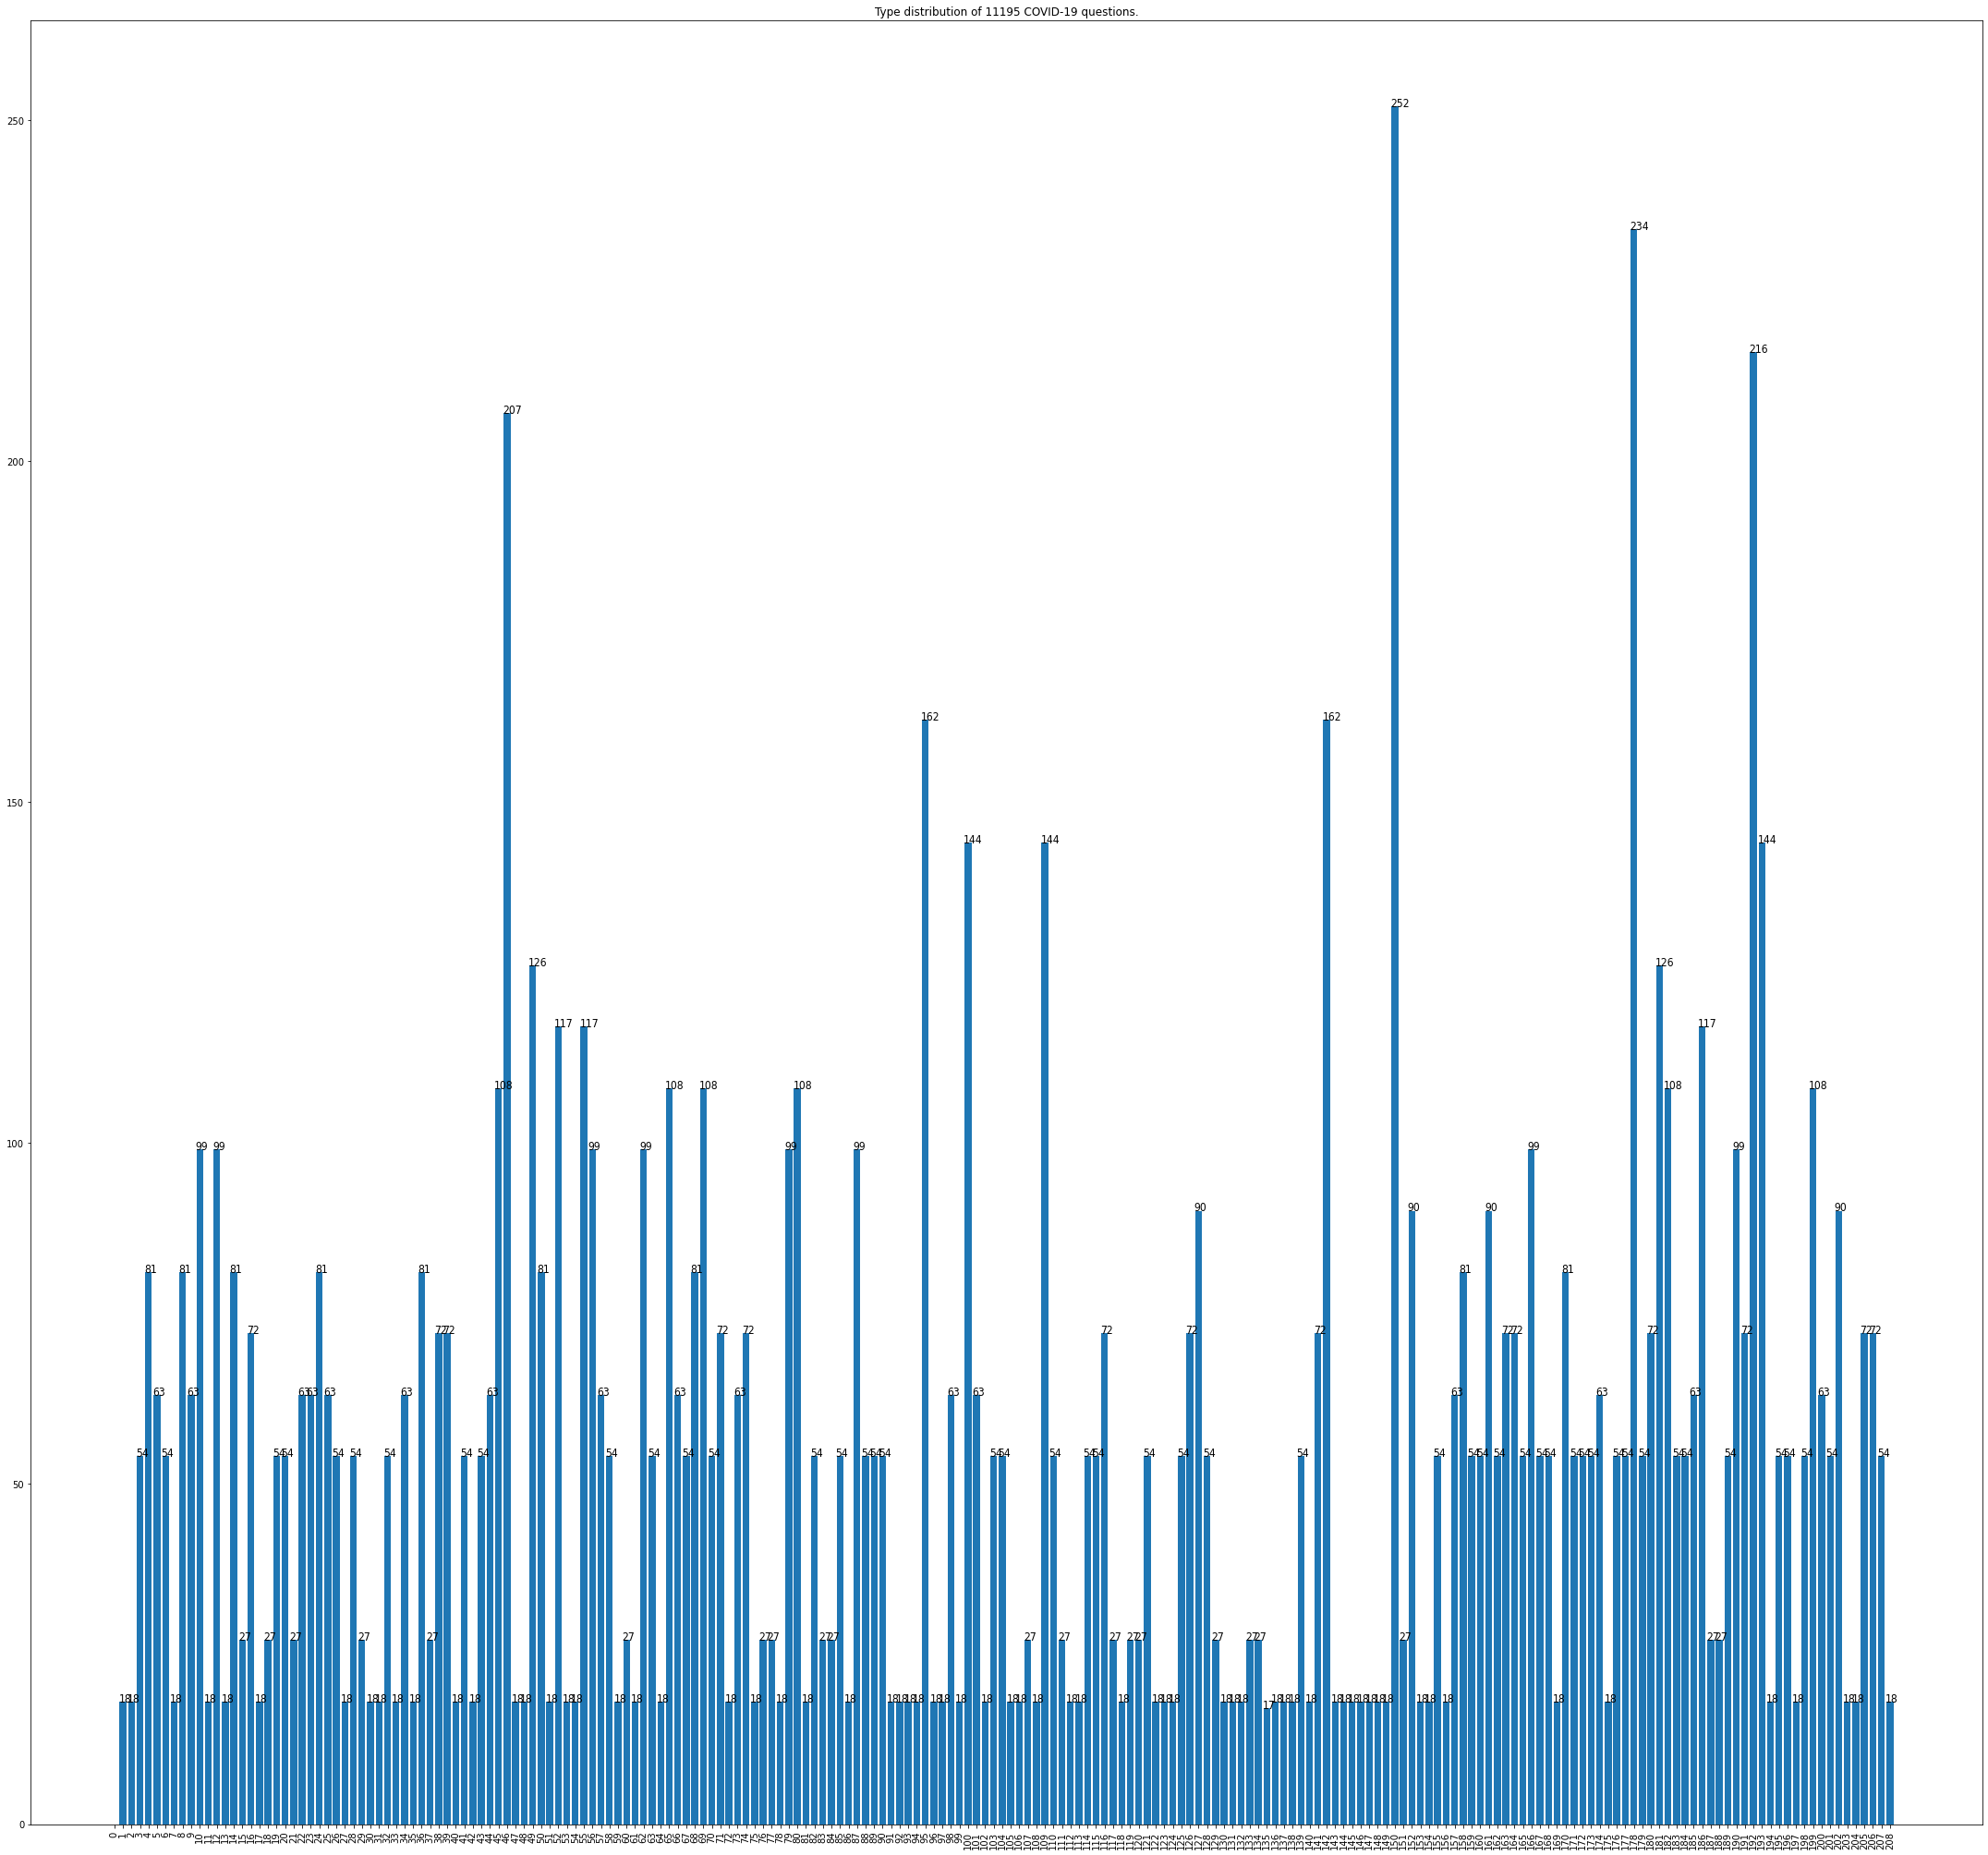

In [3]:
f = lambda x: df_tl[df_tl['label'] == x].shape[0]

comment_types = df_tl['label'].unique().tolist()
comment_counts = [f(x) for x in comment_types]

fig, ax = plt.subplots(1, 1, figsize = (30, 28))
plt.bar(comment_types, comment_counts)
ax.set_title(f"Type distribution of {len(df_tl)} COVID-19 questions.")

for index,data in zip(comment_types,comment_counts):
    plt.text(x=index-0.5 , y =data , s=f"{data}" , fontdict=dict(fontsize=12, clip_on = True, fontstretch = 'ultra-condensed'))
    
xticks = list(range(0, max(comment_types) + 1))
plt.xticks(xticks,rotation = 90)

plt.tight_layout();

As you can see that after oversampling, the "smallest" categories which used to only have 2 sampling questions now have 18 sentences.

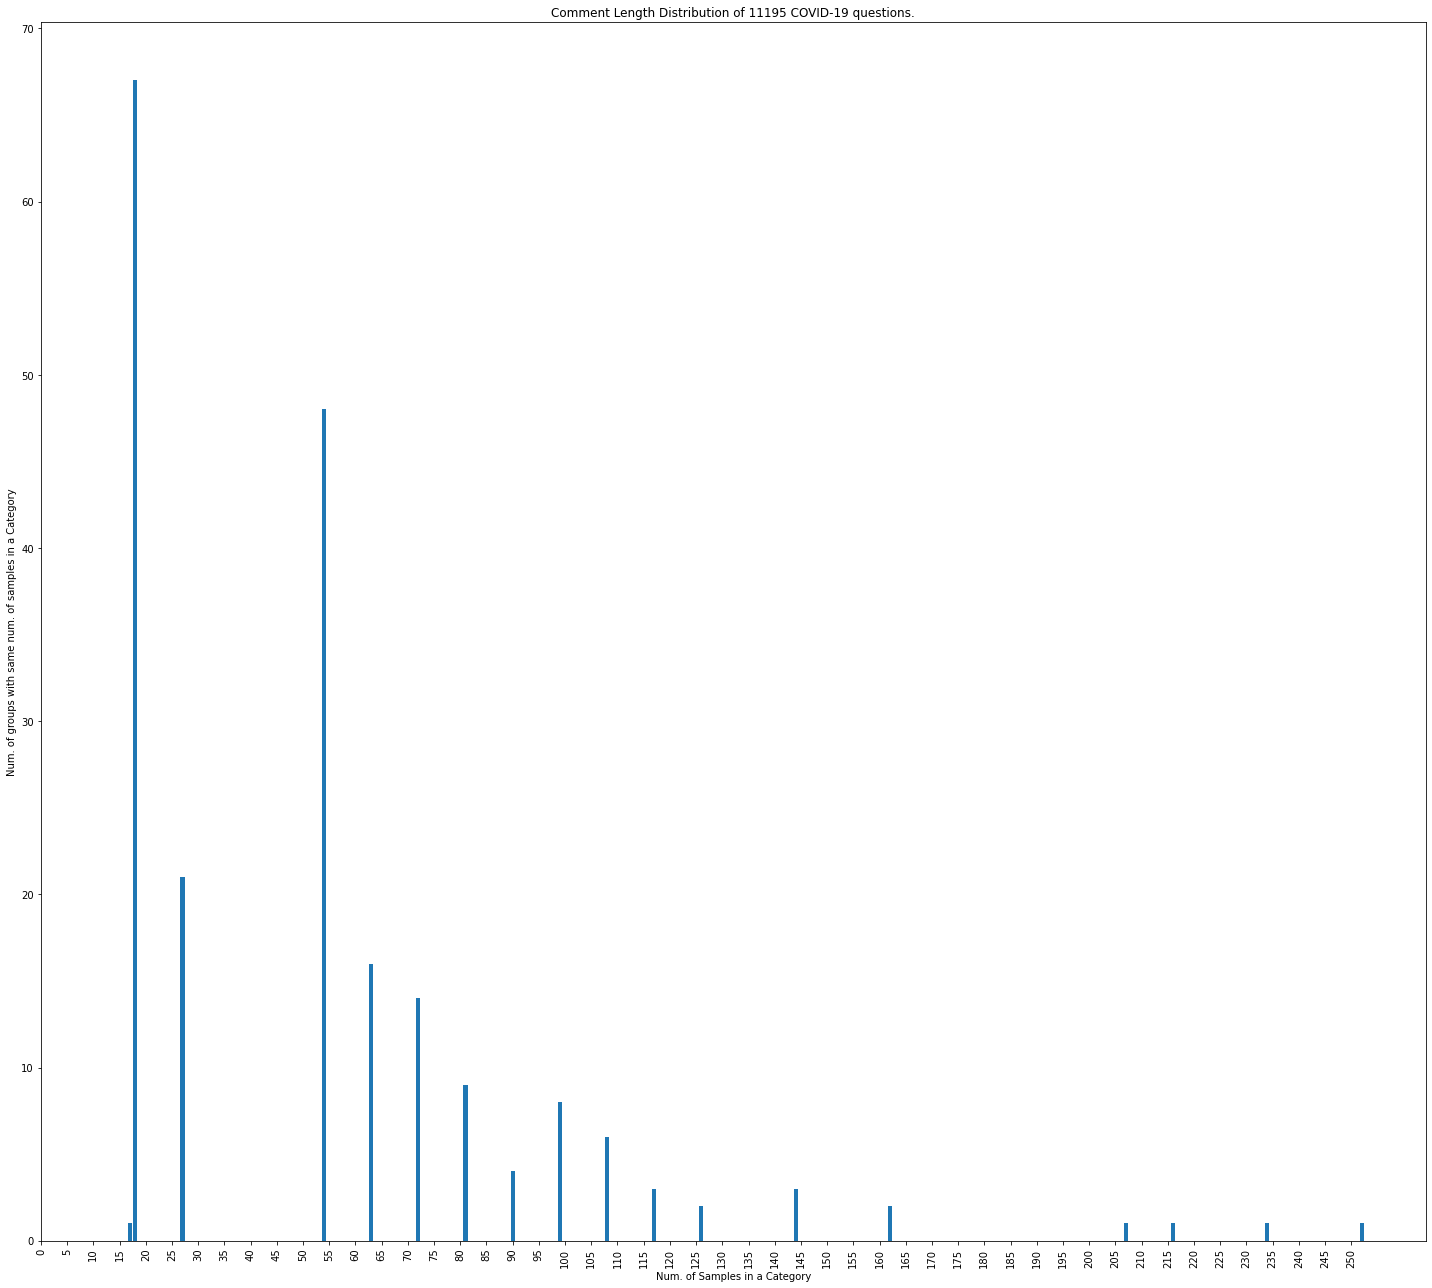

In [6]:
values = set(comment_counts)
dicts = dict.fromkeys(values, 0)

for key in comment_counts:
    dicts[key] += 1

fig, ax = plt.subplots(1, 1, figsize = (20, 18))
plt.bar(dicts.keys(), dicts.values())

ax.set_title(f"Comment Length Distribution of {len(df_tl)} COVID-19 questions.")
ax.set_ylabel('Num. of groups with same num. of samples in a Category')
ax.set_xlabel('Num. of Samples in a Category')

xticks = list(range(0, max(values) + 1, 5))
plt.xticks(xticks,rotation = 90)

plt.tight_layout();

Grouped by the number of sampling sentences in a category, we now can see the imbalanced data. But do we really want to balance the data by keeping increasing number of sampling sentences in "small" categories? 
After playing around data augmentation, I can see that by using SS and SP, the good number for how many times of generated data we would like to have is around 8. I tried to generate 10 times more data as well and I saw that the augmentor started to generate duplicated sentences. This will lead to poor quality data which defeats its purpose. So that's why I stopped at generating 8 times augmented data.

Another solution to combat the imbalanced data is to train separated models. 
We can divide the categories against the number of their sampling data. For example, we could have groups like:

1. Model 30, for all categories which have number of sampling data less than 30
2. Model 90, for all categories which have number of sampling data less than 90 but greater than 30
3. Model 130, for all categories which have number of sampling data less than 130 but greater than 90
4. Model 170, for all categories which have number of sampling data less than 130 but greater than 170
5. Model High, for all the rest of categories

(You can adjust the granularity accordingly, the models above are just for the explanation.)

When classifying a question, we iterate through all models to generate pairs of prediction with probability and pick up the prediction with the highest probability.

Due to the time limited, I did not implement this, but this solution can further boost the models' performance.

In [39]:
word_path = 'words_oversampled.csv'
words_df = pd.read_csv(word_path)
words_df

,text
0,will covid end soon
1,will covid end
2,when covid will be over
3,when covid lockdown ends
4,will covid go away
...,...
14484,what are your besst trip for entertaining vernal kids during the stay at hope orders in thez tme of the covid crisises
14485,what be your beste tips fou harbor unseasoned kids during tha staying ta dwelling oders in the time of the covid crisis
14486,what are your expert crest for entertaining iong kits druing tht check at dwelling oders in the time of ttt covid crisis
14487,Waht are yor best tips for entertaining ne mineral duing the halt alt home orders in the clip of the covid crisis


## 2. Training the Covid related language mode

A language mode is a mode which is used to predict what's the next word people going to say.
For example, if I typed: `When will covid be` and the language mode will predict the next word e.g. `over`.

We train this Covid related language mode based on the pretrained Wiki language mode(which is built in with Fast AI). So in this way, the newly trained Covid related language mode will not only have knowledge of the wiki corpus but also have the covid related vocabulary which is excellent~!

In [41]:
def get_questions(path):
    return words_df['text'].tolist()

dls_lm = DataBlock(
    blocks = TextBlock.from_df(words_df, is_lm=True),
    get_items=get_questions,
    splitter=RandomSplitter(0.2)
).dataloaders(word_path, bs=80)

When training the language mode(LM), there are 2 techniques:
1. One Cycle Policy, which enable me to train model faster
2. Progressive Model Training, in which I unfreeze the last few layers step by step over training iterations to fine tune the model

In [42]:
lm_learner = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [43]:
lm_learner.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.289480,5.119205,0.200113,167.202316,00:05


SuggestedLRs(valley=tensor(0.0030))

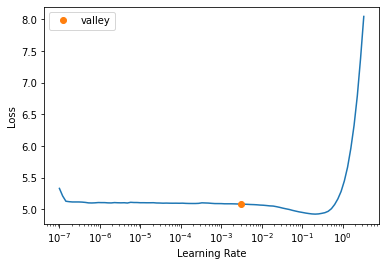

In [44]:
lm_learner.lr_find()

In [45]:
lm_learner.save('lm_mode_0epoch-o')

Path('models/lm_mode_0epoch-o.pth')

In [49]:
lm_learner.freeze_to(-2)
lm_learner.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.893191,4.364637,0.279593,78.620888,00:05


SuggestedLRs(valley=tensor(0.0010))

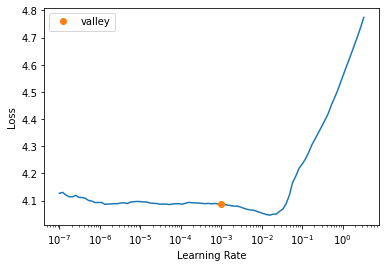

In [50]:
lm_learner.lr_find()

In [51]:
lm_learner.freeze_to(-3)
lm_learner.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.040408,4.303759,0.288200,73.977325,00:05


SuggestedLRs(valley=tensor(0.0003))

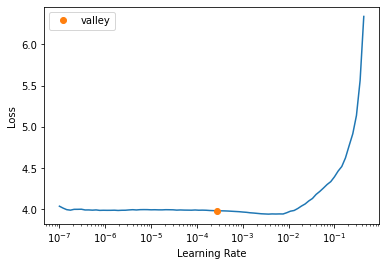

In [52]:
lm_learner.lr_find()

In [54]:
lm_learner.unfreeze()
lm_learner.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.598821,4.040595,0.317335,56.860168,00:05
1,3.508066,3.844568,0.340649,46.738480,00:05
2,3.301570,3.649353,0.366025,38.449772,00:05
3,3.037413,3.602710,0.384964,36.697567,00:06
4,2.757734,3.554047,0.394053,34.954479,00:05
5,2.495431,3.557000,0.395515,35.057873,00:05
6,2.261318,3.600240,0.394421,36.607037,00:05
7,2.069057,3.630299,0.396583,37.724098,00:05
8,1.914929,3.663396,0.397264,38.993546,00:05
9,1.809281,3.663662,0.397467,39.003902,00:05


In [56]:
lm_learner.save_encoder('lm_mode_30epoch_encoder-0')

##  3.Training the Text Classifier

Finally, with our LM trained, it's time to train the Text Classification model.

In [57]:
question_label_path = 'ql_oversampled.csv'
df_labels = pd.read_csv(question_label_path)

null_columns=df_labels.columns[df_labels.isnull().any()]
df_labels[null_columns].isnull().sum()

Series([], dtype: float64)

In [58]:
df_labels.tail()

,text,label
11190,do iodin need two stock up jn food,61
11191,wo i nedd to stock up on nutrient,61
11192,perform is need to stock certificate up on foor,61
11193,exercise ye need to stock ap on food,61
11194,do I necessitate to stock upwards on Feed,61


In [83]:
df_labels.shape

(11195, 2)

In [86]:
def getTextLabels(arg):
    df = pd.read_csv(arg)
    return df[['text', 'label']]

textBlock = (TextBlock.from_df(text_cols = ['text'], vocab=dls_lm.vocab),CategoryBlock)

dls_clas = DataBlock(
    blocks=textBlock,
    get_x = ColReader(cols='text'),
    get_y = ColReader(cols = "label"),
    get_items= getTextLabels,
    splitter = TrainTestSplitter(test_size = 0.2, random_state = 21, stratify=df_labels["label"])
).dataloaders(question_label_path, bs=80)

/home/winstonfan/anaconda3/envs/fastai24/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [62]:
dls_clas.show_batch(max_n=3)

,text,category
0,xxbos ths dth states xxunk 5 % of the worlds popolation but about xxrep 3 x % of covid cases xxunk being the xxunk nation on there xxunk where did it rifle xxmaj i 'll xxunk,142
1,xxbos xxmaj hou foulopp xxmaj they infection rata of covid make up xxunk xxunk in thi uracil . s. than information technologies be in chinaware even though china is more compact xxmaj ande xxunk xxunk,142
2,xxbos thd xxunk has 5 % off the worlds population but aboute xxunk xxunk % og covid case despite be the full bodied nation on dth major planet there xxunk information technology go wrong,142


From above, you can see that Fast AI has done all the heavy lifting for us

Here I use `to_fp16()` which is the Mixed Precision Training (also known as Half Precision). This is particularly import if there is an NVIDIA GPU with tensor cores, since it can speed up the training by 200% or more. So why not :)

In [87]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

In [88]:
learn = learn.load_encoder('lm_mode_30epoch_encoder-0')

SuggestedLRs(valley=tensor(0.0025))

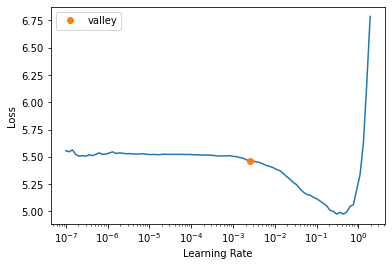

In [66]:
learn.lr_find()

In [89]:
learn.fit_one_cycle(1, 2.5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.329894,3.603492,0.316213,00:02


SuggestedLRs(valley=tensor(0.0191))

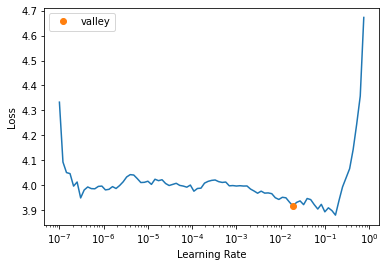

In [90]:
learn.lr_find()

In [91]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(6.3e-3/(2.6**4),6.3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.220106,1.957478,0.519875,00:02
1,1.898840,0.867395,0.791425,00:02
2,1.213078,0.682842,0.833408,00:02


SuggestedLRs(valley=tensor(3.6308e-05))

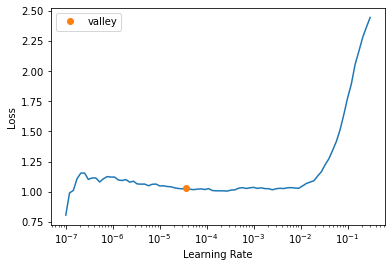

In [92]:
learn.lr_find()

In [93]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(3.6308e-5/(2.6**4),3.6308e-5))

epoch,train_loss,valid_loss,accuracy,time
0,1.022963,0.669213,0.837874,00:02
1,1.004337,0.663498,0.835194,00:02
2,1.021610,0.650330,0.839214,00:02


SuggestedLRs(valley=tensor(0.0005))

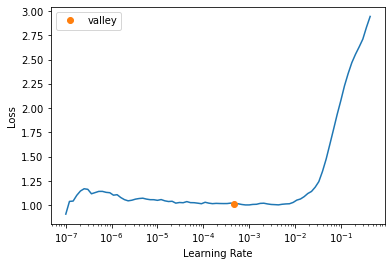

In [94]:
learn.lr_find()

In [95]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.972300,0.622179,0.845467,00:03
1,0.912695,0.553847,0.870478,00:03
2,0.810309,0.466404,0.887896,00:03
3,0.728420,0.391202,0.903975,00:03
4,0.626401,0.353336,0.911568,00:03
5,0.545357,0.317537,0.924967,00:03
6,0.494738,0.296004,0.931219,00:03
7,0.456898,0.288182,0.935239,00:03
8,0.448385,0.281602,0.935686,00:03
9,0.421318,0.277847,0.938365,00:03


SuggestedLRs(valley=tensor(3.0200e-05))

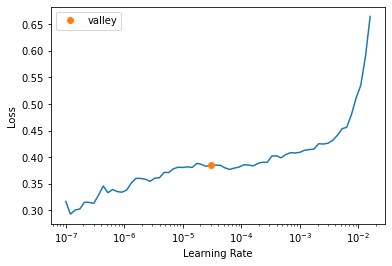

In [96]:
learn.lr_find()

# As we can see that the LR line has lost it form, so better to stop now

As we can see that the line graph of Learning Rate Finder has lost its form, so it's better to stop training at here to prevent overfitting.

So by now I have achieved 93.8% accuracy with training against oversampled data for the Text Classification Model.

I also keep the previous final training result which was trained against the original data. The accuracy was 46.1%.

So 93.8% v.s. 46.1%, such a dramatic perfermance boost~!

In [37]:
# DO NOT RUN
# Previous final training result with the original data without applying data augmentation techniques
# learn.fit_one_cycle(10, slice(1.4e-3/(2.6**4),1.7e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.045912,2.955413,0.397590,00:01
1,2.027317,2.907552,0.401606,00:01
2,1.979156,2.834939,0.409639,00:01
3,1.899435,2.761639,0.429719,00:01
4,1.810929,2.710932,0.429719,00:01
5,1.710833,2.658292,0.461847,00:01
6,1.626712,2.612600,0.445783,00:01
7,1.532489,2.605771,0.465863,00:01
8,1.465309,2.601258,0.461847,00:01
9,1.402200,2.604327,0.461847,00:01


In [98]:
learn.summary()

SequentialRNN (Input shape: 80)
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
LSTM                                                           
LSTM                                                           
LSTM                                                           
RNNDropout                                                     
RNNDropout                                                     
RNNDropout                                                     
BatchNorm1d                               2400       True      
Dropout                                                        
____________________________________________________________________________
                     80 x 50             
Linear                                    60000      True      
ReLU                                                           
BatchNorm1d                               100        True      
Dropout                                

I was aslo thinking of the Confusion matrix and found that there are too many categories squeezed into the matrix, so it's the same for ROC....

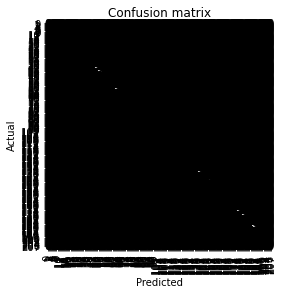

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()